# Multinomial Naive Bayes Classification

### Bayes Theorem:

### $ P(C | A) = \frac{P(A | C) * P(C)}{P(A)} $

A classification model will be built by using the Bayes Theorem.
Furthermore, the accuracy/error-rate and the F$_{1}$-Score: will be estimated to measure the model's performance.

- Success rate (accuracy):  83.51%
- Error rate: 16.49%

- Positive class:
    - Precision: 0.83
    - Recall: 0.84
    - F$_{1}$-Score: 0.84
    
<br>

- Negative class:
    - Precision: 0.84
    - Recall: 0.83
    - F$_{1}$-Score: 0.83

## Reading dataset
To get an understanding of the dataset, the first five lines will be displayed

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd 'drive/My Drive/Colab/'
except ImportError as e:
    pass

In [2]:
# Importing pandas
import pandas as pd

# Creating dataframe
imdb_frame = pd.read_csv('IMDB Dataset.csv')

# Displaying first records
imdb_frame.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Check for data imbalance
Duplicated records will be removed in order to gain more unique reviews.
Also the length of both positive and negative reviews will be calculated to check the balance of the data.

In [3]:
# Removing duplicates to gain only unique reviews
imdb_frame = imdb_frame.drop_duplicates()
print("Positive reviews: {}".format(len(imdb_frame[imdb_frame['sentiment'] == 'positive'])))
print("Negative reviews: {}".format(len(imdb_frame[imdb_frame['sentiment'] == 'negative'])))

Positive reviews: 24884
Negative reviews: 24698


## Balancing the data

In [4]:
imdb_positive = imdb_frame[imdb_frame["sentiment"] == "positive"]
imdb_negative = imdb_frame[imdb_frame["sentiment"] == "negative"]
# dropping difference between positive and negative examples.
if len(imdb_positive) != len(imdb_negative):
    imdb_positive = imdb_positive.iloc[186: , : ]
    imdb_frame = pd.concat([imdb_positive,imdb_negative], ignore_index=True)
    imdb_frame.sample(frac=1).reset_index(drop=True)
# Result after balancing
print(imdb_frame["sentiment"].value_counts())

positive    24698
negative    24698
Name: sentiment, dtype: int64


## Removing HTML Tags
Since the Reviews were retrieved from a website, it is quite helpful to remove (almost) all HTML tags for better sentiment analysis and text processing by using regular expressions.

In [5]:
imdb_frame['review'] = imdb_frame['review'].str.replace(r'<[^<>]*>', '', regex=True)

## Stemming and encoding data / target
As additional preprocessing steps, we are stemming each word to reduce it back to its root form.

In [6]:
import numpy as np
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Downloading punkt package
# nltk.download('punkt')

# Applying PorterStemmer to reduce word back to its root form 
stemmer = PorterStemmer()
imdb_frame['review'] = imdb_frame['review'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

# Creating training data
imdb_data = imdb_frame.drop(columns=['sentiment'])['review'].values
# Creating training target
imdb_target = imdb_frame.drop(columns=['review'])

# Initializing a label encoder for the training target
label_encoder = preprocessing.LabelEncoder()

# Encoding training target
imdb_target = label_encoder.fit_transform(imdb_target.values.ravel())

## Classifier and splitting data into train/test data

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating classifier and TfidVectorizer to implement stop word removal
nb_estimator = MultinomialNB()
transformer = TfidfVectorizer(use_idf = False, stop_words='english')
densetransformer = DenseTransformer()

# Splitting data
train_data, test_data, train_target, test_target = train_test_split(imdb_data, imdb_target, test_size=0.20, random_state = 42)

# Define pipeline
pipeline = Pipeline(steps=[('transformer',transformer),('to_dense', densetransformer),('estimator',nb_estimator)])

## Hyperparameter Optimization

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Setting hyperparameters
parameters = {
    'transformer__min_df': list(np.arange(0.002,0.033,0.004)),
    'transformer__max_df': list(np.arange(0.09,0.13,0.003))
}

# GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)
estimator = GridSearchCV(pipeline, parameters, cv=cv, scoring='accuracy', n_jobs=-1)
estimator.fit(train_data, train_target)
# Get best params
print(estimator.best_params_)

{'transformer__max_df': 0.11100000000000002, 'transformer__min_df': 0.002}


## Define function to plot confusion matrix

Source: https://www.uni-mannheim.de/media/Einrichtungen/dws/Files_Teaching/Data_Mining/HWS2022/exercise/03_Classification.zip (File: DM_Exercise_3_Python_Classification_Intro_KNN_Centroid.ipynb)

In [9]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Error analysis

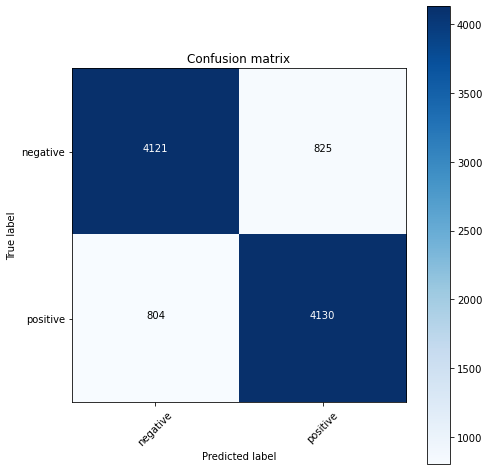

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83      4946
    positive       0.83      0.84      0.84      4934

    accuracy                           0.84      9880
   macro avg       0.84      0.84      0.84      9880
weighted avg       0.84      0.84      0.84      9880

Accuracy: 83.51214574898785%
Error rate: 16.487854251012145%


In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cross-validation-prediction for error analysis
prediction = cross_val_predict(estimator, test_data, test_target, cv=cv)
# Creating confusion matrix
cm = confusion_matrix(test_target, prediction)
# Preparing plot for confusion matrix
plot_confusion_matrix(cm, classes = label_encoder.classes_)
plt.show()

# Printing classification report et. al. to show accuracy, precision/recall and F1-Score
print(classification_report(test_target, prediction, target_names=label_encoder.classes_))
# Accuracy of model
accuracy = accuracy_score(test_target, prediction)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"Error rate: {(1 - accuracy) * 100.0}%")